
0. import data
1.   Define objective function (total time = travel time + waiting time + inspection time)
2.   Generate population (random matrix NPOP x (n+2*k))


*   NPOP= number of individuals in population
*   n=number of establishments
*   k=0,1*n= number of vehicles
*   2*k is added to consider starting and ending point of each vehicle
3. evaluate fitness
* (-)objective function (greatest fit the one with less total time)
4. order population by fitness
5.   select parents
6.   crossover
7. mutation
8. update population
9. evaluate fitness
10. order population by fitness
11. go back to 5 until stopping criteria



In [ ]:
import numpy as np
import copy, random, math
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import time

# importing data from google drive cloud
def import_excel(): 
  url='https://drive.google.com/file/d/1vu3UhfxA61Ksu3z85LSqKeHusGynPeKn/view?usp=sharing'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  df = pd.read_csv(url)
  distances = np.array(df.iloc[0:, 0:].values)


  url='https://drive.google.com/file/d/1lsplyuLXJ5W5WELVWlJEP0DiGVCY0faA/view?usp=sharing'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  df2 = pd.read_csv(url)
  inspection_times=np.array(df2.iloc[:, 8].values) #inspection_times-array with inspection times
  latitudes=np.array(df2.iloc[:, 5].values)
  longitudes=np.array(df2.iloc[:, 6].values)

  column_data = df2.iloc[:, -1]
  data_list = [[int(x) for x in row.strip('][').split(', ')] for row in column_data]
  schedule = np.array(data_list)
  #np.set_printoptions(threshold=np.inf)   # to print ALL the lines
  return distances,inspection_times,schedule, latitudes, longitudes

In [ ]:
import numpy as np
import copy, random, math
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import time

# importing data locally
# WILL NOT WORK ON GOOGLE COLAB
def import_excel(): 
    file_path=r'C:\Users\user\Desktop\ai\data.xlsx'

    df = pd.read_excel(file_path, sheet_name='distances')
    distances = np.array(df.iloc[1:, 1:].values, dtype=float) #distances-matrix with distances

    df2 = pd.read_excel(file_path, sheet_name='establishments')
    inspection_times=np.array(df2.iloc[:, 8].values) #inspection_times-array with inspection times
    latitudes=np.array(df2.iloc[:, 5].values)
    longitudes=np.array(df2.iloc[:, 6].values)

    # Extract the last column of the DataFrame
    column_data = df2.iloc[:, -1]
    # Convert the column data into a list of lists
    data_list = [[int(x) for x in row.strip('][').split(', ')] for row in column_data]
    # Convert the list of lists into a NumPy array
    schedule = np.array(data_list)
    return distances,inspection_times,schedule, latitudes, longitudes

In [ ]:
class InspectionRouteProblem:
    def __init__(self, distances, inspection_times, schedule, n):
        num_vehicles=int(n/10)
        self.distances = distances
        self.inspection_times = inspection_times
        self.schedule = schedule
        self.num_vehicles = num_vehicles
        self.num_establishments = 10
        
    def evaluate_solution(self, individual):
        routes = np.reshape(individual, (self.num_vehicles, self.num_establishments +2))
        previous_time=0
        total_time = 0
        for vehicle in routes: #iterates for each vehicle
            total_time_v = 0
            travel_time = 0
            inspection_time = 0           
            current_time = 9   #every route starts at 9 AM
            for i in range(len(vehicle) - 1):
                waiting_time = 0
                start = vehicle[i]
                end = vehicle[i + 1]
                travel_time += self.distances[start][end] / 3600 #time it took to get from establishment start to end, in hours
                inspection_time += self.inspection_times[start] / 60 #time it took to inspect establishment start, in hours
                open_hours = self.schedule[start]
                arrival_time = current_time + travel_time
                if arrival_time >= 24: #checks if the passes midnight
                    arrival_time -= 24
                if open_hours[int(arrival_time)] == 1: #checks if the establishment is open on arrival
                    current_time = arrival_time + self.inspection_times[start] / 60 #updates hour of the day
                else:
                    waiting_time += int(arrival_time) + 1 - arrival_time #process to calculate the waiting time until it opens
                    next_open_time = int(arrival_time) + 1
                    if next_open_time == 24:
                        next_open_time = 0
                    while open_hours[next_open_time] == 0:
                        waiting_time += 1
                        next_open_time += 1
                        if next_open_time == 24:
                          next_open_time = 0
                    current_time = arrival_time + waiting_time + self.inspection_times[start] / 60 #updates hour of the day
            total_time_v += travel_time + inspection_time + waiting_time #total time for this vehicle to inspect 10 establishments 
            if total_time_v>previous_time: #updates the longest route
                total_time=total_time_v
            previous_time=total_time_v
        return -total_time

In [ ]:
def get_greatest_fit(population,scores):
    best_solution = population[0]
    best_score = scores[0]
    for i in range(1, len(population)):
        score = scores[i]
        if score > best_score:
            best_score = score
            best_solution = population[i]
    return best_solution, best_score

def ordered_random_two_point_crossover(solution_1, solution_2):
    #Performs ordered random two-point crossover between two solutions
    length = len(solution_1)
    crossover_points = sorted([random.randint(0, length), random.randint(0, length)])
    zeros = [i for i in range(length) if solution_1[i] == 0 or solution_2[i] == 0]
    child_1 = [0] * length
    child_2 = [0] * length
    
    # First child
    for i in range(crossover_points[0], crossover_points[1]):
        child_1[i] = solution_1[i]
    j = 0
    for i in range(length):
        if solution_2[i] not in child_1 and solution_2[i] != 0:
            if i not in zeros:
                child_1[i] = solution_2[i]
                j += 1
        else:
            child_1[i] = solution_1[i]
    
    # Second child
    for i in range(crossover_points[0], crossover_points[1]):
        child_2[i] = solution_2[i]
    j = 0
    for i in range(length):
        if solution_1[i] not in child_2 and solution_1[i] != 0:
            if i not in zeros:
                child_2[i] = solution_1[i]
                j += 1
        else:
            child_2[i] = solution_2[i]
    
    return child_1, child_2

def offspring(parents): #generates offspring through crossover
    num_parents = (len(parents))
    offspring = []
    for i in range(0, num_parents, 2):
        solution_1 = parents[i]
        solution_2 = parents[i+1]
        child_1, child_2 = ordered_random_two_point_crossover(solution_1, solution_2)
        # Convert strings to numpy arrays
        child_1 = np.array([int(digit) for digit in child_1[1:-1]])
        child_2 = np.array([int(digit) for digit in child_2[1:-1]])
        child_1= np.concatenate(([0], child_1, [0]))
        child_2= np.concatenate(([0], child_2, [0]))
        offspring.append(child_1)
        offspring.append(child_2)
    return offspring

def generate_random_solution(n):     #generates a random solution, that consists in the routes of every vehicle combined
    values = np.random.permutation(np.arange(1, n + 1))
    values_with_zeros = []
    count = 0
    for i, val in enumerate(values):
        if count == 10:
            values_with_zeros.extend([0, 0])
            count = 0
        values_with_zeros.append(val)
        count += 1
    if count > 0 and count < 10:
        num_zeros = 10 - count
        values_with_zeros.extend([0] * num_zeros)
    return np.concatenate(([0], values_with_zeros, [0]))    

def generate_population(population_size,n):
    solutions = []
    for i in range(population_size):
        solutions.append(generate_random_solution(n))
    return solutions

def print_population(population):
    solutions = []
    for i in range(len(population)):
        print(f"Solution {i}: {population[i]}, {problem.evaluate_solution(population[i])}")
        solutions.append(population[i])
    return np.array(solutions)

def tournament_select(population, tournament_size, scores): #tournament selection
    population_copy = copy.deepcopy(population)
    best_solution = population_copy[0]
    best_score = scores[0]
    for i in range(tournament_size):
        index = np.random.randint(0, len(population_copy))
        score = scores[index]
        if score > best_score:
            best_score = score
            best_solution = population_copy[index]
        del population_copy[index]
    return best_solution

def replace_worst_individuals(population, offspring,scores):
    # sort population by fitness in ascending order
    
    sorted_indices = np.argsort(scores)
    sorted_population = [population[i] for i in sorted_indices]

    # replace the worst individuals in the sorted population with offspring
    num_offspring = len(offspring)
    for i in range(num_offspring):
        sorted_population[-(i+1)] = offspring[i]

    # return the updated population
    return sorted_population

def roulette_select(population,scores): #roulette selection
    score_sum = np.sum(scores)
    selection_probabilities = scores / score_sum
    return population[np.random.choice(len(population), p=selection_probabilities)]

def roulette_select_pool(population, pool_size, scores): #roulette selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = roulette_select(population, scores)
        pool.append(selected_solution)
    return pool

def tournament_select_pool(population, pool_size, tournament_size, scores): #tournament selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = tournament_select(population, tournament_size, scores)
        pool.append(selected_solution)
    return pool    

def roulette_and_tournament_select_pool(population, pool_size, tourn_p, tournament_size, scores): #combines roulette and tournament selection to a pool
    roulette_size = int(pool_size * (1 - tourn_p))
    tournament_pool_size = int(pool_size * tourn_p)
    pool = roulette_select_pool(population, roulette_size, scores)
    tournament_pool = tournament_select_pool(population, tournament_pool_size, tournament_size, scores)
    pool.extend(tournament_pool)
    return pool   

def pool_select_parents(population_size, pool, Pcross):  #selects parents from the pool with Pcross percentage of the population to be chose as parents
    num_parents = int(population_size * Pcross)
    if num_parents % 2 == 1:
      num_parents -= 1
    parent_indices = []
    selected_parents = set()
    while len(selected_parents) < num_parents:
        x = np.random.randint(len(pool))
        individual = tuple(pool[x])
        if individual not in selected_parents:
            selected_parents.add(individual)
            parent_indices.append(x)
    parents = [pool[i] for i in parent_indices]
    return parents
    
def mutate_solution(solution, problem):
    num_swaps=(problem.num_vehicles)  #makes the number of swaps in mutation be adjusted to the data size
    non_zero_indices = [i for i in range(len(solution)) if solution[i] != 0]
    indices = random.sample(non_zero_indices, num_swaps)
    for i in range(0, len(indices), 2):
        index_1 = indices[i]
        index_2 = indices[i+1]
        solution[index_1], solution[index_2] = solution[index_2], solution[index_1]
    return solution

def mutate_population(population, Pmutate,p_nei, problem,n):
    mutated_population = []
    #numbers = sum(population, [])
    #x=len(numbers)
    #y=int(x/12)
    #routes = np.reshape(population, (y,12))
    for individual in population:
        if np.random.rand() < Pmutate:
            if np.random.rand() <p_nei:    #gives p_nei probability of mutation be performed via local search (two-opt)
              mutated_individual = get_neighbour_solution(individual,problem,n)
            else:
              mutated_individual = mutate_solution(individual,problem)
        else:
            mutated_individual = individual
        mutated_population.append(mutated_individual)
    return mutated_population
                   

def evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population(offsp, Pmutate,p_nei,problem,n)
    population=replace_worst_individuals(population, offsp,scores)    
    return population

def get_neighbour_solution(tour, problem,n): #two-opt
    zeros_indices = np.where(tour == 0)[0]  # get the indices of the zeros in the tour
    zeros_positions = zeros_indices.argsort()  # get the positions of the zeros in the tour
    tour_without_zeros = tour[tour != 0]  # remove the zeros from the tour
    best_tour = tour
    best_time = problem.evaluate_solution(tour)
    t = len(tour_without_zeros)
    for i in range(1, t-1, int(n/20)):
        for j in range(i+1, t,int(n/20)):
            new_tour_without_zeros = np.concatenate((tour_without_zeros[:i], tour_without_zeros[i:j+1][::-1], tour_without_zeros[j+1:]))
            count=0
            count_2=0
            new_tour=np.zeros(len(tour))
            for k in range(len(tour)):   
                if k != zeros_indices[count]:      
                    new_tour[k]=new_tour_without_zeros[count_2]
                    count_2+=1
                else:
                    count+=1  
            new_time = problem.evaluate_solution(new_tour.astype(int))
            if new_time > best_time:
                best_tour = new_tour
                best_time = new_time
    return best_tour.astype(int)

def problem(distances, inspection_times, schedule, n):
    problem = InspectionRouteProblem(distances, inspection_times, schedule, n)
    return problem

In [ ]:
#num_iterations is the max number of iterations without change in the optimal value
#population_size is self explainable
#n is the number of establishments
#Pcross is the percentage of the population we want to select as parents
#pool_size is the size of the pool, in which we put all the contestants to be selected as parents
#tourn_p is the percentage of the pool that is selected via tournament, the rest is with roullete
#tournament_size is how many "battles" I want to do in the tournament
#Pmutate is the probability of mutation
#p_nei is the probability of mutating with local search, via two-opt. It gives a better mutation, but requires more computational effort, therefor for big data sets should be smaller
#--------------------------------------------------------------------------

def genetic_algorithm(num_iterations, population_size, n, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, problem,  log=False):
    start_time = time.time()
    distances,inspection_times,schedule, latitudes, longitudes=import_excel() 
    problem=problem(distances, inspection_times, schedule, n)
       
    population = generate_population(population_size,n)
    #print_population(population)
    best_solution = population[0] # Initial solution
    best_score = problem.evaluate_solution(population[0])
    best_solution_generation = 0 # Generation on which the best solution was found
    iterations=num_iterations #saves the number of executed iterations
    generation_no = 0
    
    print(f"Initial solution: {best_solution}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    best_scores = []
    best_solutions = []
    generations=[]
    while(num_iterations > 0):
        
        generation_no += 1
        
        scores = []
        # loop through each individual in the population
        for individual in population:
        # evaluate the individual's solution and append the score to the scores list
          scores.append(problem.evaluate_solution(individual))
        scores = np.array(scores)
        # Next generation
        population=evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n)
        #print(f"population evolved in generation {generation_no}: {population}")
        # Checking the greatest fit among the current population
        greatest_fit, greatest_fit_score = get_greatest_fit(population,scores)
        if greatest_fit_score > best_score:
            best_solution = greatest_fit
            best_score = greatest_fit_score
            best_solution_generation = generation_no
            best_scores.append(-best_score)
            best_solutions.append(best_solution)
            generations.append(generation_no)
            if log:
                print(f"\nGeneration: {generation_no }")
                print(f"Solution: {best_solution}, score: {best_score}")
                #print_population(population)
        else:
            num_iterations -= 1
    end_time = time.time()
    time_running= round(end_time - start_time,3)  
    print(f"  Final solution: {best_solution}, time to inspect all establishments: {int(abs(best_score))} h {int((abs(best_score) % 1)*60)} min")
    print(f"  Found on generation {best_solution_generation}")
    print(f"  Number of vehicles utilized: {int(n/10)}")
    print(f"  Number of inspected economic operators: {n}")
    # plot evolution data  
    plt.plot(generations, best_scores)
    plt.xlabel('Generation')
    plt.ylabel('Time to inspect all establishments [h]')
    plt.title('Evolution of Best Solution')
    plt.show()

    #ID list
    vehicles = np.reshape(best_solution, (int(n/10), 12))
    # initialize table with headers
    table= PrettyTable()
    table.field_names = ['Vehicle', 'IDs']
    # iterate over each route in the list of routes
    for i, route in enumerate(vehicles):
      # add row to the table for the current route
      table.add_row([f'Vehicle {i+1}', route])
    # print the table
    print(table)
    print(f"total time spent running the algorithm: {time_running} s")
    print(f"number of iterations to reach the optimal solution: {best_solution_generation}")
    print(f"total number of iterations executed: {best_solution_generation+iterations}")
    return best_solution

Initial solution: [ 0  1 19  6  2 15 10  9 20 18  5  0  0 14  7 16 17 13 12  3  8 11  4  0], time to inspect all establishments: 27 h 30 min
  Final solution: [ 0 12  4 17 11  6  5 14  2 19 10  0  0  8 20  7  1 13 18  9  3 15 16  0], time to inspect all establishments: 15 h 5 min
  Found on generation 8
  Number of vehicles utilized: 2
  Number of inspected economic operators: 20


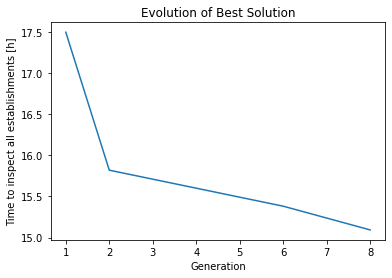

+-----------+---------------------------------------+
|  Vehicle  |                  IDs                  |
+-----------+---------------------------------------+
| Vehicle 1 | [ 0 12  4 17 11  6  5 14  2 19 10  0] |
| Vehicle 2 | [ 0  8 20  7  1 13 18  9  3 15 16  0] |
+-----------+---------------------------------------+
total time spent running the algorithm: 12.846 s
number of iterations to reach the optimal solution: 8
total number of iterations executed: 108


In [ ]:
result_20_establishments = genetic_algorithm(100,20,20,0.7,100,0.4,4,0.5,0.2,problem) #20

Initial solution: [  0   5   2  88   6  40  67  46  68  79  91   0   0   9  24  77  31  12
  42  75  90  72  95   0   0  11  25  76  32  26  51  33  63  69  14   0
   0  62  93  27  43  94  98  21  65  38  29   0   0  20  56  92  30  53
  74  58  66  84  96   0   0  59  78   1  39  64  37  54  13  81  10   0
   0  57  36  73  16  34  19  87  86  22  18   0   0  99   4  85  82  44
   7  23  49  83  89   0   0  45  61 100  52  35  70   3  50  71  97   0
   0  28  80  41   8  47  15  60  48  55  17   0], time to inspect all establishments: 22 h 42 min
  Final solution: [  0  49   7  79  50  56  48  66  58  35  29   0   0  39  16   5 100  41
  83  59  95  14   9   0   0  85  19  76   8  65   4  42  47  25  26   0
   0  81  68  19  63  44  46   2  28  54  15   0   0  51  88  24  30  92
  86  87  90  45  20   0   0  34  10  73  40  17  96  99  89  84  13   0
   0  94  27  36  12  33  43  37   1  52  61   0   0  31  93  70  60  22
  43  68  78   3  21   0   0  23  56  66  53  62  50  14  15  

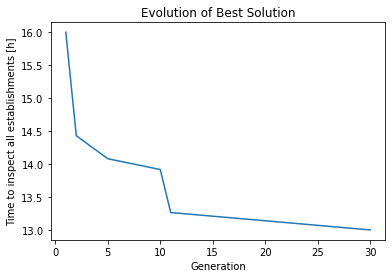

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  |       [ 0 49  7 79 50 56 48 66 58 35 29  0]       |
| Vehicle 2  | [  0  39  16   5 100  41  83  59  95  14   9   0] |
| Vehicle 3  |       [ 0 85 19 76  8 65  4 42 47 25 26  0]       |
| Vehicle 4  |       [ 0 81 68 19 63 44 46  2 28 54 15  0]       |
| Vehicle 5  |       [ 0 51 88 24 30 92 86 87 90 45 20  0]       |
| Vehicle 6  |       [ 0 34 10 73 40 17 96 99 89 84 13  0]       |
| Vehicle 7  |       [ 0 94 27 36 12 33 43 37  1 52 61  0]       |
| Vehicle 8  |       [ 0 31 93 70 60 22 43 68 78  3 21  0]       |
| Vehicle 9  |       [ 0 23 56 66 53 62 50 14 15 32 38  0]       |
| Vehicle 10 |       [ 0 69 87 95  8 30 80 21 79 27 98  0]       |
+------------+---------------------------------------------------+
total time spent running the algorithm: 54.188 s
number of ite

In [ ]:
result_100_establishments = genetic_algorithm(50,30,100,0.7,120,0.5,10,0.7,0.4,problem)

Initial solution: [  0 116 466 463 305 299 144 492 368 461 231   0   0 497  24  95 479 141
 162  54 428 287 158   0   0 275 146  62 195  69 257 264 315 496 136   0
   0 411 303 204 290 260 172 163  28 498 445   0   0 449 109 219 367 185
 111  59 129 434 456   0   0 393 329 323 403 131 296 151 370 485 110   0
   0 304 481 181 487 174 362 429  60  70 222   0   0 192  81 425 308 239
  94 285 182  40 424   0   0 371 199  15 458  36 120 451 134 246 169   0
   0 455 280 420 432  35 210 196 347 433 328   0   0 179 369   5 409 213
 334 173 263 168 454   0   0 457  18  19  49 102  96 346 446 189  98   0
   0 437  56 490 107 150 145 245 389  79 224   0   0 105 160  37 499  51
 225  47 202  34 316   0   0 212 354 484 205 340  72 124 155  82 152   0
   0 238 344 383 301   4 314 349 360 423  55   0   0 229  16 122 251 471
 396 309  74 477 384   0   0 137  76 187  80  97 265 390 380  25 294   0
   0 177  90 480 159 139 440 140 214 175 149   0   0 448 357   3 271 379
 289 108 232 253  83   0   0 310 

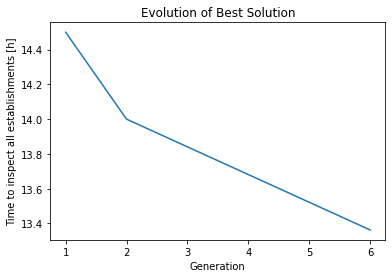

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  | [  0 274 358 204 310 117 227  28 497  61 266   0] |
| Vehicle 2  | [  0  78 275  54 221  42 121 235 110 177 407   0] |
| Vehicle 3  | [  0 343  12 295 237   2 455 375  79 255 138   0] |
| Vehicle 4  | [  0  51 137 353 415 194  83   4 302 473 146   0] |
| Vehicle 5  | [  0  64  29 291 203 426 430  48 113 254 103   0] |
| Vehicle 6  | [  0 382 151 452 142  59 459 494 199  80 298   0] |
| Vehicle 7  | [  0 408  11  77  60 149 413 338 299 450 125   0] |
| Vehicle 8  | [  0 100 325 448 434  20 395 440  94 171 359   0] |
| Vehicle 9  | [  0 140  19 362 364 387 401 429  73 388 318   0] |
| Vehicle 10 | [  0  70 350 360 398   6 425  61 136 290 147   0] |
| Vehicle 11 | [  0  15 263 435 205 243 143 174 316 206 317   0] |
| Vehicle 12 | [  0 405 233 165 296 300 154 391 315 167 222   

In [ ]:
result_500_establishments = genetic_algorithm(50,20,500,0.7,300,0.5,10,0.6,0.1,problem)

Initial solution: [  0 949  10 ... 342 217   0], time to inspect all establishments: 30 h 57 min
  Final solution: [  0 479 472 ... 267 803   0], time to inspect all establishments: 15 h 26 min
  Found on generation 5
  Number of vehicles utilized: 100
  Number of inspected economic operators: 1000


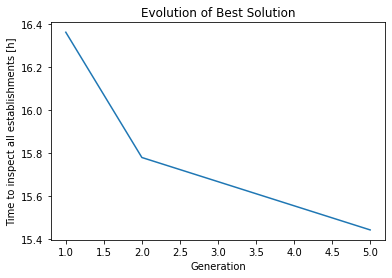

+-------------+---------------------------------------------------------------+
|   Vehicle   |                              IDs                              |
+-------------+---------------------------------------------------------------+
|  Vehicle 1  |       [  0 479 472 811 178  99 392  10 164 245 675   0]       |
|  Vehicle 2  | [   0  435  955  758  239  207 1000  437  358  110  232    0] |
|  Vehicle 3  |       [  0 329 969 285 304 397 170 451 744 823 976   0]       |
|  Vehicle 4  |       [  0 883 280 782 579 530 200  81 618 864 105   0]       |
|  Vehicle 5  |       [  0 951 335  25 794 904 596  68 960 411  29   0]       |
|  Vehicle 6  |       [  0 871 534 768 190 515  45 859 708 258 654   0]       |
|  Vehicle 7  |       [  0 230 824 747 237 600 381 367 981 502 443   0]       |
|  Vehicle 8  |       [  0 449 758 781 811 454 824 201 212 882 867   0]       |
|  Vehicle 9  |       [  0 241 342 318 892 383 750  14 850  10 133   0]       |
|  Vehicle 10 |       [  0 361 756 547 4

In [ ]:
result_1000_establishments = genetic_algorithm(50,25,1000,0.6,700,0.4,20,0.3,0.1,problem)

In [ ]:
#Simulated annealing

def get_neighbour_solution(tour, problem,n):
    zeros_indices = np.where(tour == 0)[0]  # get the indices of the zeros in the tour
    zeros_positions = zeros_indices.argsort()  # get the positions of the zeros in the tour
    tour_without_zeros = tour[tour != 0]  # remove the zeros from the tour
    best_tour = tour
    best_time = problem.evaluate_solution(tour)
    t = len(tour_without_zeros)
    for i in range(1, t-1, int(n/20)):
        for j in range(i+1, t,int(n/20)):
            new_tour_without_zeros = np.concatenate((tour_without_zeros[:i], tour_without_zeros[i:j+1][::-1], tour_without_zeros[j+1:]))
            count=0
            count_2=0
            new_tour=np.zeros(len(tour))
            for k in range(len(tour)):   
                if k != zeros_indices[count]:      
                    new_tour[k]=new_tour_without_zeros[count_2]
                    count_2+=1
                else:
                    count+=1  
            new_time = problem.evaluate_solution(new_tour.astype(int))
            if new_time > best_time:
                best_tour = new_tour
                best_time = new_time
    return best_tour.astype(int)

def get_sa_solution(num_iterations, problem,n, log=False):
    start_time = time.time()
    distances,inspection_times,schedule, latitudes, longitudes=import_excel() 
    problem=problem(distances, inspection_times, schedule, n)    
    iteration = 0;
    iterations_exec=0 #number of iterations executed
    temperature = 1000;
    solution = generate_random_solution(n) # Best solution after 'num_iterations' iterations without improvement
    score = problem.evaluate_solution(solution)
    
    best_solution = copy.deepcopy(solution)
    best_score = score
    best_scores=[]
    print(f"Initial Solution:  {best_solution},  time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    initial_solution = best_solution
    while iteration < num_iterations:
        temperature = temperature * 0.999  # Test with different cooling schedules
        iteration += 1
        iterations_exec+=1
        neighbour_solution = get_neighbour_solution(best_solution,problem,n)  #Test with Neighbour 1, 2 and 3
        neighbour_score = problem.evaluate_solution(neighbour_solution)
        delta = neighbour_score - score 
        
        if delta > 0 or np.exp(-delta/temperature) > random.random():
            solution = neighbour_solution
            score = neighbour_score
            if score > best_score:
                iteration = 0
                best_solution = copy.deepcopy(solution)
                best_score = score 
                best_scores.append(-score)
                if log:
                    print(f"Solution:       {best_solution}, score: {best_score},  Temp: {temperature}")
    end_time = time.time()
    time_running= round(end_time - start_time,3)                
    print(f"Final Solution: {best_solution}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    print(f"  Number of vehicles utilized: {int(n/10)}")
    print(f"  Number of inspected economic operators: {n}")
    # plot evolution data  
    plt.plot(list(range(1, len(best_scores)+1)), best_scores)
    plt.xlabel('best solution')
    plt.ylabel('Time to inspect all establishments [h]')
    plt.title('Evolution of Best Solution')
    plt.show()

    #ID list
    vehicles = np.reshape(best_solution, (int(n/10), 12))
    # initialize table with headers
    table= PrettyTable()
    table.field_names = ['Vehicle', 'IDs']
    # iterate over each route in the list of routes
    for i, route in enumerate(vehicles):
      # add row to the table for the current route
      table.add_row([f'Vehicle {i+1}', route])
    # print the table
    print(table)
    print(f"total time spent running the algorithm: {time_running} s")
    print(f"number of iterations to reach the optimal solution: {iterations_exec-num_iterations}")
    print(f"total number of iterations executed: {iterations_exec}")    
    return best_solution, initial_solution 

Initial Solution:  [ 0  4 19  5 11  7 12  9  6 15 10  0  0 17 14 18 13 20 16  8  2  3  1  0],  time to inspect all establishments: 29 h 25 min
Final Solution: [ 0  4 11 20  7 13 18 16 14  8 17  0  0 19 12  3  1 10 15  9  5  6  2  0], time to inspect all establishments: 15 h 0 min
  Number of vehicles utilized: 2
  Number of inspected economic operators: 20


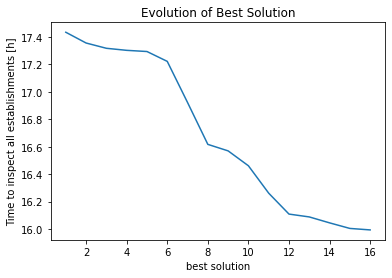

+-----------+---------------------------------------+
|  Vehicle  |                  IDs                  |
+-----------+---------------------------------------+
| Vehicle 1 | [ 0  4 11 20  7 13 18 16 14  8 17  0] |
| Vehicle 2 | [ 0 19 12  3  1 10 15  9  5  6  2  0] |
+-----------+---------------------------------------+
total time spent running the algorithm: 11.373 s
number of iterations to reach the optimal solution: 16
total number of iterations executed: 316


In [ ]:
SA_20_establishments=get_sa_solution(300,problem,20)
best = SA_20_establishments[0]
initial = SA_20_establishments[1]

In [ ]:
import folium

# generate initial and final solutions

# The establishment locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SOLUTION:\n")
# The solution order
solution_order = initial

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m

INITIAL SOLUTION:



In [ ]:

print("FINAL SOLUTION:\n")
# The solution order
solution_order = best

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m


FINAL SOLUTION:



Initial Solution:  [  0  44  67  95  56 100  15  24  29  61  98   0   0  33  55  35  79  26
  81  13  68  14  43   0   0  84  71  46  50  12  73  52  63  41  20   0
   0  74  49  88  21   6  72  93  28  70  40   0   0  32  80  42  16  27
  75  65  89  18  39   0   0  25  85  23  90   2  87  57  45  99  51   0
   0  10  76  17  96  82  58  83  34  92  38   0   0  97   5  47  19  37
   8  36   3  66   1   0   0   7  62  60  69  77  30  86  54  53  64   0
   0  31  59  91  11   4  78  22   9  48  94   0],  time to inspect all establishments: 23 h 37 min
Final Solution: [  0  44  67  95  56 100  15  24  29  61  98   0   0  33  55  35  79  26
  81  13  68  14  43   0   0  84  71  46  50  12  73  52  63  41  20   0
   0  74  49  88  21   6  72  93  28  70  40   0   0  32  80  42  16  27
  75  65  89  18  39   0   0  25  85  23  90   2  87   9  22  78   4   0
   0  11  91  59  31  64  53  54  86  30  77   0   0  69  60  62   7   1
  66   3  36   8  37   0   0  19  47   5  97  38  92  76  17  

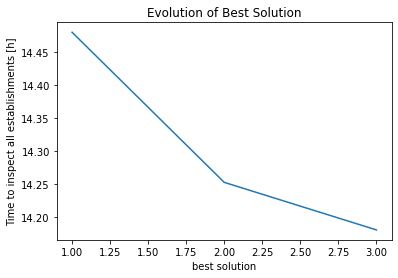

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  | [  0  44  67  95  56 100  15  24  29  61  98   0] |
| Vehicle 2  |       [ 0 33 55 35 79 26 81 13 68 14 43  0]       |
| Vehicle 3  |       [ 0 84 71 46 50 12 73 52 63 41 20  0]       |
| Vehicle 4  |       [ 0 74 49 88 21  6 72 93 28 70 40  0]       |
| Vehicle 5  |       [ 0 32 80 42 16 27 75 65 89 18 39  0]       |
| Vehicle 6  |       [ 0 25 85 23 90  2 87  9 22 78  4  0]       |
| Vehicle 7  |       [ 0 11 91 59 31 64 53 54 86 30 77  0]       |
| Vehicle 8  |       [ 0 69 60 62  7  1 66  3 36  8 37  0]       |
| Vehicle 9  |       [ 0 19 47  5 97 38 92 76 17 96 82  0]       |
| Vehicle 10 |       [ 0 58 83 34 10 51 99 57 45 48 94  0]       |
+------------+---------------------------------------------------+
total time spent running the algorithm: 8.682 s
number of iter

In [ ]:
SA_100_establishments=get_sa_solution(50,problem,100)

Initial Solution:  [  0 355 109  65 411 314 208  20 169 477 380   0   0  87 405 326  51  73
 146 454 211  49 268   0   0  21 295  13  11 439 230 333  27 309  67   0
   0 199 376 266 108 142  64 406 259  26 491   0   0 166 437 126 315  74
 375 116 185 361 432   0   0 421 104 493 447 444   6 479 354 483 419   0
   0 465  89 398 253 277 288  75  70 428 434   0   0   8 134 446 270 455
 351 137  52 252 370   0   0 285  36 427  19 332 478 131 271 400   5   0
   0 147 383  17  33 346  88 374 156 128 144   0   0 415  60 423 470 418
 348 403 240 318  50   0   0  10 381 172 365 342 155 113  76 163  66   0
   0 221  58 160 180 256 192  45 222 279   1   0   0 122 182  38 377 234
   4 352 359 200  14   0   0  63 368 345 148 141 143 263 280 391 473   0
   0  68 274 399 157 344 165  15 262 159 178   0   0 291 241 453 425 112
  97 492 283 402  94   0   0  71 210 438 390  41 257  28 416  29 322   0
   0 475  39  85 298 154 161 181  35 474 233   0   0 281 347 349 248 363
  98  95 366  93 440   0   0 443

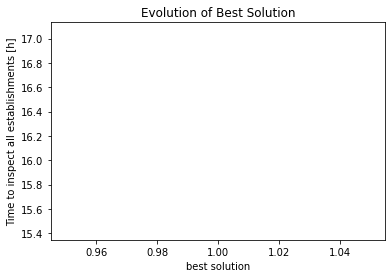

+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  | [  0 355 109  65 411 314 208  20 169 477 380   0] |
| Vehicle 2  | [  0  87 405 326  51  73 146 454 211  49 268   0] |
| Vehicle 3  | [  0  21 295  13  11 439 230 333  27 309  67   0] |
| Vehicle 4  | [  0 199 376 266 108 142  64 406 259  26 491   0] |
| Vehicle 5  | [  0 166 437 126 315  74 375 116 185 361 432   0] |
| Vehicle 6  | [  0 421 104 493 447 444   6 479 354 483 419   0] |
| Vehicle 7  | [  0 465  89 398 253 277 288  75  70 428 434   0] |
| Vehicle 8  | [  0   8 134 446 270 455 351 137  52 252 370   0] |
| Vehicle 9  | [  0 285  36 427  19 332 478 131 271 400   5   0] |
| Vehicle 10 | [  0 147 383  17  33 346  88 374 156 128 144   0] |
| Vehicle 11 | [  0 415  60 423 470 418 348 403 240 318  50   0] |
| Vehicle 12 | [  0  10 381 172 365 342 155 113  76 163  66   

In [ ]:
SA_500_establishments=get_sa_solution(50,problem,500)

Initial Solution:  [  0 938 879 ... 213 442   0],  time to inspect all establishments: 19 h 44 min
Final Solution: [  0 938 879 ... 213 442   0], time to inspect all establishments: 19 h 44 min
  Number of vehicles utilized: 100
  Number of inspected economic operators: 1000


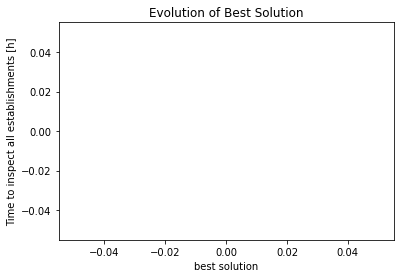

+-------------+---------------------------------------------------------------+
|   Vehicle   |                              IDs                              |
+-------------+---------------------------------------------------------------+
|  Vehicle 1  |       [  0 938 879  95  79 490 568 237  85 960 941   0]       |
|  Vehicle 2  |       [  0 410 255 860 493 431 141 601 876 952 771   0]       |
|  Vehicle 3  |       [  0 671 197 387 767 305 776 458 549 307 228   0]       |
|  Vehicle 4  |       [  0 742 841 499  69   7 708 558  22 812 815   0]       |
|  Vehicle 5  |       [  0 578 359 273 674 732 654 633 620 146 244   0]       |
|  Vehicle 6  |       [  0 216 350   1 975 844 733 241 120 418 487   0]       |
|  Vehicle 7  |       [  0 310 564 339 907 994 889 606 388 764 494   0]       |
|  Vehicle 8  |       [  0 927 163 579 125 180 585 555 810 320 591   0]       |
|  Vehicle 9  |       [  0  66 997 300 853 703 303 676 436 543 559   0]       |
|  Vehicle 10 |       [  0 823 902 210 4

In [ ]:
SA_1000_establishments=get_sa_solution(50,problem,1000)

In [ ]:
#Resource allocation minimization - Genetic Algorithm
def generate_random_solution2(n):
    # Generate a random permutation of the numbers from 1 to k
    values = np.random.permutation(np.arange(1, n + 1))
    return [int(x) for x in values]

def generate_population2(population_size,n):
    solutions = []
    for i in range(population_size):
        solutions.append(generate_random_solution2(n))
    return solutions

    

def invert_mutation(solution):
    """
    Randomly select two cities in the genotype and reverse the order of the cities between them.
    """
    # Select two distinct cities at random
    i, j = sorted(random.sample(range(1, len(solution)-1), 2))
    # Reverse the order of cities between i and j
    new_solution = solution[:i] + solution[j:i-1:-1] + solution[j+1:]
    return new_solution

def swap_mutation(solution):
    # Select two random cities to swap
    idx1, idx2 = random.sample(range(1, len(solution) - 1), 2)
    # Swap their positions in the genotype
    solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
    return solution

def mutate_population2(population, Pmutate,p_nei, problem):
    mutated_population = []
    for individual in population:
        if np.random.rand() < Pmutate:
            if np.random.rand() <p_nei:
              mutated_individual = swap_mutation(individual)
            else:
              mutated_individual = swap_mutation(individual)
        else:
            mutated_individual = individual
        mutated_population.append(mutated_individual)
    return mutated_population
                   

def evolve_population2(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population2(offsp, Pmutate,p_nei,problem)
    population = replace_worst_individuals(population, offsp,scores)
    return population

def evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population(offsp, Pmutate,p_nei,problem,n)
    population=replace_worst_individuals(population, offsp,scores)    
    return population


#Resource allocation minimization
INSPECTION_TIME = 5/60  # it takes 5 min (300 sec) to inspect each establishment

class ResourceAllocationMinimization:
    def __init__(self, distances, inspection_times, schedule, n):
        self.distances = distances
        self.inspection_time = inspection_times / 3600
        self.schedule = schedule
        self.num_establishments = n

    # solution is a list of establishment indices, e.g. [4 1 5 3 2]
    def evaluate_solution(self, solution):
        route = list(solution)
        total_travel_time = self.distances[0][route[0]] / 3600
        total_inspection_time = 0
        total_waiting_time = 0                  
        waiting_time = 0
        current_time = 9 + total_travel_time
        current_vehicle = 1
        visited_nodes = []

        # print(route)
        # print('\n')
        for i in range(len(route) - 1):            
            waiting_time = 0
            start = route[i]
            end = route[i + 1]
            if current_time - 9 >= 8 or current_time + self.distances[start][end] / 3600 - 9 >= 8:
                # print(f"working day for vehicle {current_vehicle} was finished here {current_time}")
                # print(f"visited nodes: {visited_nodes}")
                # print(f"it has stopped at establishment {solution[i-1]}\n")
                current_vehicle += 1
                current_time = 9
                visited_nodes = []
                # the new vehicle starts at 9 am and works until 5 pm
                # it should start from node 0 and go to the next unvisited establishment
                total_travel_time += self.distances[0][route[i + 1]] / 3600
                current_time += self.distances[0][route[i + 1]] / 3600            
            total_travel_time += self.distances[start][end] / 3600
            open_hours = self.schedule[start]                          
            current_time += self.distances[start][end] / 3600
            # check if establishment is open
            if open_hours[int(current_time)] == 1:
                total_inspection_time += INSPECTION_TIME
                current_time += INSPECTION_TIME
            # if not, wait until it opens                 
            else:
                waiting_time += int(current_time) + 1 - current_time 
                next_open_time = int(current_time) + 1
                current_time += waiting_time
                while open_hours[next_open_time] == 0 and current_time - 9 <= 8:
                    waiting_time += 1
                    next_open_time += 1 
                    current_time += waiting_time                
                total_inspection_time += INSPECTION_TIME
                total_waiting_time += waiting_time
                current_time += INSPECTION_TIME
            visited_nodes.append(start)  
        total_time = total_travel_time + total_inspection_time + total_waiting_time
        # print(f"working day for vehicle {current_vehicle} was finished at {current_time}. It finished at establishment {solution[i+1]}")
        # print(f"visited nodes: {visited_nodes}")
        # print(f"total waiting time: {total_waiting_time}")
        # print(f"total inspection time: {total_inspection_time}")
        # print(f"total time: {total_time}")
        return -current_vehicle

def problem2(distances, inspection_time, schedule, n):
    problem = ResourceAllocationMinimization(distances, inspection_time, schedule, n)
    return problem


def genetic_algorithm2(num_iterations, population_size, n, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, problem,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem2(distances, INSPECTION_TIME, schedule, n)  
    
  population = generate_population2(population_size,n)
  best_solution = population[0] # Initial solution
  best_score = problem.evaluate_solution(population[0])
  best_solution_generation = 0 # Generation on which the best solution was found
  generation_no = 0
    
  print(f"Initial solution: {best_solution}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  best_scores = []
  best_solutions = []
  generations=[]
  while(num_iterations > 0):
    generation_no += 1
    scores = []
    for individual in population:
      scores.append(problem.evaluate_solution(individual))
    scores = np.array(scores)

    population = evolve_population2(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem)
    # Checking the greatest fit among the current population
    greatest_fit, greatest_fit_score = get_greatest_fit(population,scores)
    if greatest_fit_score > best_score:
            best_solution = greatest_fit
            best_score = greatest_fit_score
            best_solution_generation = generation_no
            best_scores.append(-best_score)
            best_solutions.append(best_solution)
            generations.append(generation_no)
            if log:
                print(f"\nGeneration: {generation_no }")
                print(f"Solution: {best_solution}, score: {best_score}")
    else:
            num_iterations -= 1
            generations.append(generation_no)
            best_scores.append(-best_score)
    #print(f"best solution {generation_no}th generation - {best_score}")  # uncomment to check every geenration difference
  end_time = time.time()
  time_running= round(end_time - start_time,3)  
  print(f"  Final solution: best_solution, vehicles required to inspect all establishments: {-best_score} ")
  print(f"  Found on generation {best_solution_generation}")
  # plot evolution data  
  plt.plot(generations, best_scores)
  plt.xlabel('Generation')
  plt.ylabel('number of vehicles required')
  plt.title('Evolution of Best Solution')
  plt.show()

  print(f"total time spent running the algorithm: {time_running} s")
  return best_solution

Initial solution: [82, 704, 559, 595, 680, 871, 658, 913, 820, 735, 764, 378, 800, 741, 848, 854, 718, 164, 511, 711, 229, 241, 651, 57, 616, 672, 66, 349, 278, 677, 264, 570, 407, 202, 710, 946, 984, 955, 572, 146, 332, 769, 660, 793, 67, 857, 127, 951, 147, 81, 80, 541, 305, 804, 879, 782, 198, 578, 26, 731, 742, 422, 750, 538, 828, 845, 50, 619, 973, 30, 455, 529, 669, 415, 474, 287, 449, 465, 301, 941, 728, 758, 947, 405, 907, 771, 376, 501, 838, 581, 418, 227, 391, 786, 219, 978, 761, 137, 776, 394, 204, 354, 212, 296, 477, 751, 148, 554, 780, 860, 136, 863, 335, 737, 514, 159, 897, 687, 143, 949, 16, 633, 625, 454, 626, 370, 740, 779, 962, 987, 235, 113, 70, 921, 39, 931, 787, 166, 504, 60, 977, 214, 574, 128, 757, 830, 513, 914, 470, 886, 445, 115, 923, 528, 487, 833, 29, 476, 701, 428, 37, 745, 380, 358, 23, 495, 47, 336, 706, 160, 593, 315, 983, 340, 190, 262, 369, 903, 945, 304, 596, 374, 691, 688, 337, 934, 837, 443, 791, 661, 674, 631, 473, 359, 111, 867, 216, 970, 521, 59,

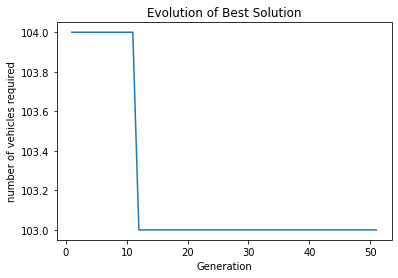

total time spent running the algorithm: 69.45 s


In [ ]:
resourceAllocationResult = genetic_algorithm2(50, 25, 1000, 0.6,700,0.4,10,0.6,0.3, problem2)

In [ ]:
def swap_establishments(solution):
    # Choose two random establishments to swap
    i, j = random.sample(range(len(solution)), 2)
    # Swap the establishments in the solution
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

def get_sa_solution(num_iterations, problem, n, log=False):
    start_time = time.time()
    distances, inspection_times, schedule, latitudes, longitudes = import_excel()
    problem = problem2(distances, inspection_times, schedule, n)    
    iteration = 0
    iterations_exec = 0  # number of iterations executed
    best_iteration = 0
    temperature = 1000
    cooling_rate = 0.95
    solution = generate_random_solution2(n)
    score = -problem.evaluate_solution(solution)  # Negate the score
    best_solution = copy.deepcopy(solution)
    best_score = score
    best_scores = []
    print(f"Initial Solution: best_solution, vehicles to inspect all establishments: {best_score}")
    initial_solution = best_solution
    while iteration < num_iterations:
        new_solution = swap_establishments(solution)
        new_score = -problem.evaluate_solution(new_solution)  # Negate the score
        
        if new_score < score:
            # Accept the new solution if it is better
            solution = new_solution
            score = new_score
        else:
            # Accept the new solution with probability based on temperature
            delta_score = new_score - score
            acceptance_probability = math.exp(-delta_score / temperature)
            if random.random() < acceptance_probability:
                solution = new_solution
                score = new_score
        
        # Update the best solution if necessary
        if score < best_score:
            best_solution = copy.deepcopy(solution)
            best_score = score
            best_iteration = iteration
        
        # Reduce the temperature by the cooling rate
        temperature *= cooling_rate
        iteration += 1
        iterations_exec += 1
        
        # Log the best score and solution
        best_scores.append(-best_score)
        if log and iterations_exec % 100 == 0:
            print(f"Iteration {iterations_exec}, Best solution: best_solution, vehicles to inspect all establishments: {-best_score}")
    
    end_time = time.time()
    time_running= round(end_time - start_time,3) 
    
    print(f"Best solution: best_solution, vehicles to inspect all establishments: {best_score}, Time elapsed: {time_running:.2f} seconds")
    print(f"Best solution found at iteration {best_iteration}")
    
    # plot evolution data  
    best_scores_positive = [-score for score in best_scores]
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.show()    
    
    
    print(f"total time spent running the algorithm: {time_running} s")

    return best_solution, -best_score, best_scores, initial_solution


Initial Solution: best_solution, vehicles to inspect all establishments: 3
Best solution: best_solution, vehicles to inspect all establishments: 1, Time elapsed: 1.73 seconds
Best solution found at iteration 4


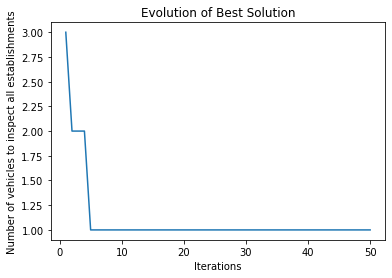

total time spent running the algorithm: 1.728 s


In [ ]:
SA_resourceAllocation=get_sa_solution(50,problem,15)
best_solution = SA_resourceAllocation[0]
negative_best_score = SA_resourceAllocation[1]
best_scores = SA_resourceAllocation[2]
initial_solution = SA_resourceAllocation[3]

INITIAL SLUTION:



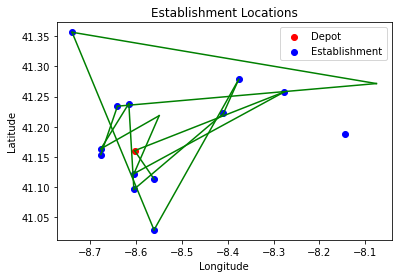

FINAL SOLUTION:


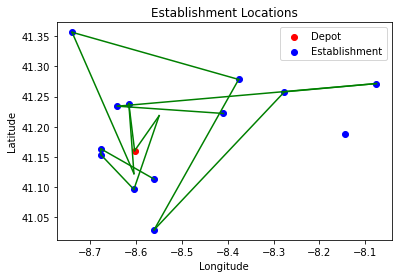

In [ ]:
import matplotlib.pyplot as plt

# generate initial and final solutions

# The establishment locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SLUTION:\n")
# The solution order
solution_order = initial_solution
# Create the figure and axis
fig, ax = plt.subplots()

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    ax.plot([locations[start, 1], locations[end, 1]], [locations[start, 0], locations[end, 0]], c='green')

# Plot the depot
ax.scatter(locations[0, 1], locations[0, 0], c='red', label='Depot')

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
ax.scatter(locations[establishments_in_path, 1], locations[establishments_in_path, 0], c='blue', label='Establishment')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Establishment Locations')
ax.legend()

# Show the plot
plt.show()

print("FINAL SOLUTION:")

solution_order = best_solution

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    ax.plot([locations[start, 1], locations[end, 1]], [locations[start, 0], locations[end, 0]], c='green')

# Plot the depot
ax.scatter(locations[0, 1], locations[0, 0], c='red', label='Depot')

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
ax.scatter(locations[establishments_in_path, 1], locations[establishments_in_path, 0], c='blue', label='Establishment')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Establishment Locations')
ax.legend()

# Show the plot
plt.show()


In [ ]:
import folium

# generate initial and final solutions

# The establishment locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SOLUTION:\n")
# The solution order
solution_order = initial_solution

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m

INITIAL SOLUTION:



In [ ]:

print("FINAL SOLUTION:\n")
# The solution order
solution_order = best_solution

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m


FINAL SOLUTION:

